# BioLLM x Plants - Extraction of Mechanistic Insights: Structure-Proprty-Stimuli Graphing & Properties to Engineered Designs Workflows

Rachel K. Luu, Ming Dao, Subra Suresh, Markus J. Buehler (2025) ENHANCING SCIENTIFIC INNOVATION IN LLMS: A FRAMEWORK APPLIED TO PLANT MECHANICS RESEARCH [full reference to be updated to be included here]

# Load BioLLM with RAG using Llamacpp

In [ ]:
import pandas as pd
import json
import itertools
from llama_index.core import VectorStoreIndex
from llama_index.core.response.notebook_utils import display_response
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex
from llama_index.llms.llama_cpp import LlamaCPP
from typing import List, Optional, Sequence
from llama_index.core import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import SimpleDirectoryReader

def completion_to_prompt(completion):
    return "<|start_header_id|>system<|end_header_id|>\n<eot_id>\n<|start_header_id|>user<|end_header_id|>\n" + \
           f"{completion}<eot_id>\n<|start_header_id|>assistant<|end_header_id|>\n"

def messages_to_prompt(messages):
    prompt = "<|start_header_id|>system<|end_header_id|>\n<eot_id>\n" 
    for message in messages:
        if message.role == "system":
            prompt += f"system message<eot_id>\n"
        elif message.role == "user":
            prompt += f"<|start_header_id|>user<|end_header_id|>\n{message.content}<eot_id>\n"
        elif message.role == "assistant":
            prompt += f"<|start_header_id|>assistant<|end_header_id|>\n{message.content}<eot_id>\n"
    prompt += "<|start_header_id|>assistant<|end_header_id|>\n"
    return prompt

model_url = "https://huggingface.co/rachelkluu/Llama3.1-8b-Instruct-CPT-SFT-DPO-09022024-Q8_0-GGUF/resolve/main/llama3.1-8b-instruct-cpt-sft-dpo-09022024-q8_0.gguf"
bioinspiredllm_q8 = LlamaCPP(
    model_url=model_url,
    model_path=None,
    temperature=.1,
    max_new_tokens=2048,
    context_window=16000,
    model_kwargs={"n_gpu_layers": -1},
    messages_to_prompt=messages_to_prompt,
    completion_to_prompt=completion_to_prompt,
    verbose=False,
)

Settings.llm = bioinspiredllm_q8
Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5"
)

documents = SimpleDirectoryReader(
    "./PlantPapers/"
).load_data()
Settings.chunk_size = 128
Settings.chunk_overlap = 50
vector_index = VectorStoreIndex.from_documents(documents)
query_engine = vector_index.as_query_engine(response_mode="compact", similarity_top_k=10) 

# Load Structure-Property-Stimuli Workflow

This workflow takes in a user-defined input of a stimuli (humidity, light, temperature) given a particular material (pollen, rhapis excelsa leaves) and then generates related mechanical properties and structures. The results can be displayed in graph format. 

In [ ]:
import itertools
import pandas as pd
import json

def extract_bullet_points(response_text):
    """Extract bullet points or numbered points from a response."""
    lines = response_text.split('\n')
    bullet_points = set()
    for line in lines:
        line = line.strip()
        if line.startswith(('- ', '• ', '* ')):
            bullet_points.add(line[2:].strip())
        elif line and line[0].isdigit() and line[1:3] == '. ':
            bullet_points.add(line[3:].strip())
        elif line.startswith('[') and line[1].isdigit() and line[2] == ']':
            bullet_points.add(line[3:].strip())
    return list(bullet_points)

def generate_propertieslist(stimuli,material):
    """Generate a list of structures relevant to a given property and material."""
    prompt = f"List the top 5 intrinsic mechanical properties of {material} influenced by changes in {stimuli}. Provide the list in bullet point format, without any explanations or additional context."
    all_questions = []
    data_for_df = []
    response = query_engine.query(prompt)
    questions = extract_bullet_points(response.response)
    print(f"Generated properties:\n")
    for q in questions:
        print(f"- {q}")
    all_questions.append(questions)
    for ques in questions:
        data_for_df.append({"Stimuli": stimuli, "Material": material, "Property": ques})
    flat_questions = list(itertools.chain.from_iterable(all_questions))
    df = pd.DataFrame(data_for_df, columns=["Stimuli", "Material", "Property"])
    return df, flat_questions

def generate_propanswers(df, stimuli):
    """Generate rationales for each property generated before"""
    answers = []
    for idx, row in df.iterrows():
        prop = row["Property"]
        material = row["Material"]
        txt = f"Describe concisely how the mechanical property, {[prop]}, is influenced by changes in {stimuli} in {material}. Focus on its primary mechanism or role, and critically assess its significance. No citations."
        answer = query_engine.query(txt).response
        answers.append(answer)
        df.at[idx, "Property Explanation"] = answer
    return df

def generate_structureslist(df):
    """Generate list of  structures responsible for changing each mechanical property."""
    df["Potential Structures"] = None
    for idx, row in df.iterrows():
        mech_property = row["Property"]  
        explanation = row["Property Explanation"] 
        material = row["Material"]
        stimuli = row["Stimuli"]
        
        query_text = (
            f"The {mech_property} property of {material} is influenced by changes in {stimuli}. Explanation: {explanation}. "
            f"List the intrinsic structures or architectures found in {material} that affect {mech_property}."
            f"Provide the list in bullet point format with names only, with no explanations or additional context. Limit to 10 structures."
        )
        response = query_engine.query(query_text).response
        extracted_structures = extract_bullet_points(response)
        df.at[idx, "Potential Structures"] = extracted_structures
    return df

def generate_finalstructures(df, top_struc):
    """Query the LLM to evaluate the significance of each structure, narrow down the list to the top N structures, and provide concise rationales for the selection."""
    df["Final Structures"] = None
    for idx, row in df.iterrows():
        mech_property = row["Property"] 
        structures = row["Potential Structures"] 
        material = row["Material"]
        stimuli = row["Stimuli"]
        prompt = (
            f"The following is a list of structures found in {material} that may contribute to {mech_property}:\n\n"
            f"{structures}\n\n"
            f"Identify the top {top_struc} structures or architectures that most strongly contribute to {mech_property}, particularly when in response to changing {stimuli}."
            f"Provide the list in bullet point format with names only, with no explanations or additional context. Limit to {top_struc} structures."
        )
        response = query_engine.query(prompt).response
        extracted_structures = extract_bullet_points(response)

        df.at[idx, "Final Structures"] = extracted_structures
    return df


def run_spsworkflow(stimuli, material):
    print(f"For {material}...")
    print(f"\nGenerating properties for stimuli: {stimuli}...")
    df, num_mechprop =generate_propertieslist(stimuli, material)
    print(f"\n{len(num_mechprop)} properties generated.")
    print("\nGenerating explanations for each property...")
    df = generate_propanswers(df, stimuli)
    print("\nGenerating potential structures for each property...")
    df = generate_structureslist(df)
    print(f"\nNarrowing down to final {len(num_mechprop)} structures for each property...")
    df = generate_finalstructures(df, top_struc=len(num_mechprop))
    return df


# Inference Structure-Property-Stimuli

In [ ]:
######### USER INPUT #############


stimuli = "humidity"
material = "pollen grains"

##################################

sps_df = run_spsworkflow(stimuli, material)
sps_df

For pollen grains...

Generating properties for stimuli: humidity...
Generated properties:

- Young's modulus
- Compressive strength
- Shear modulus
- Tensile strength
- Fracture toughness

5 properties generated.

Generating explanations for each property...

Generating potential structures for each property...

Narrowing down to final 5 structures for each property...


,Stimuli,Material,Property,Property Explanation,Potential Structures,Final Structures
0,humidity,pollen grains,Young's modulus,The mechanical property of Young's modulus in ...,"[Sporopollenin, Pollen grain vacuoles, Pollen ...","[Sporopollenin, Pollen wall, Pollen tube, Inti..."
1,humidity,pollen grains,Compressive strength,The mechanical property of compressive strengt...,"[Sporopollenin, Pollen grain vacuoles, Pollen ...","[Sporopollenin, Pollen wall, Pollen tube, Inti..."
2,humidity,pollen grains,Shear modulus,The shear modulus of pollen grains is influenc...,"[Pore plate, Tectum, Muri, Spoke, Pollen wall,...","[Muri, Spoke, Pollen wall, Intine, Exine]"
3,humidity,pollen grains,Tensile strength,The tensile strength of pollen grains is influ...,"[Sporopollenin, Pollen wall, Pollen grain vacu...","[Sporopollenin, Pollen tube, Intine, Exine, Po..."
4,humidity,pollen grains,Fracture toughness,The mechanical property of fracture toughness ...,"[Pollen cell wall, Tectum, Pectin, Sporopollen...","[Sporopollenin, Pectin, Endexine, Pollen wall,..."


## Graphing
Make sure "df" is populated with the results. Using matplotlib, first example is a basic graph and second example is a bipartite graph.  

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def load_edges(df):
    edges = []
    for _, row in df.iterrows():
        property_name = row["Property"]
        structures = row["Final Structures"]
        if isinstance(structures, str):
            structures = structures.split(";")  
        for structure in structures:
            structure = structure.strip()
            if structure:
                edges.append({"property": property_name, "structure": structure})
    return edges

edges = load_edges(sps_df)

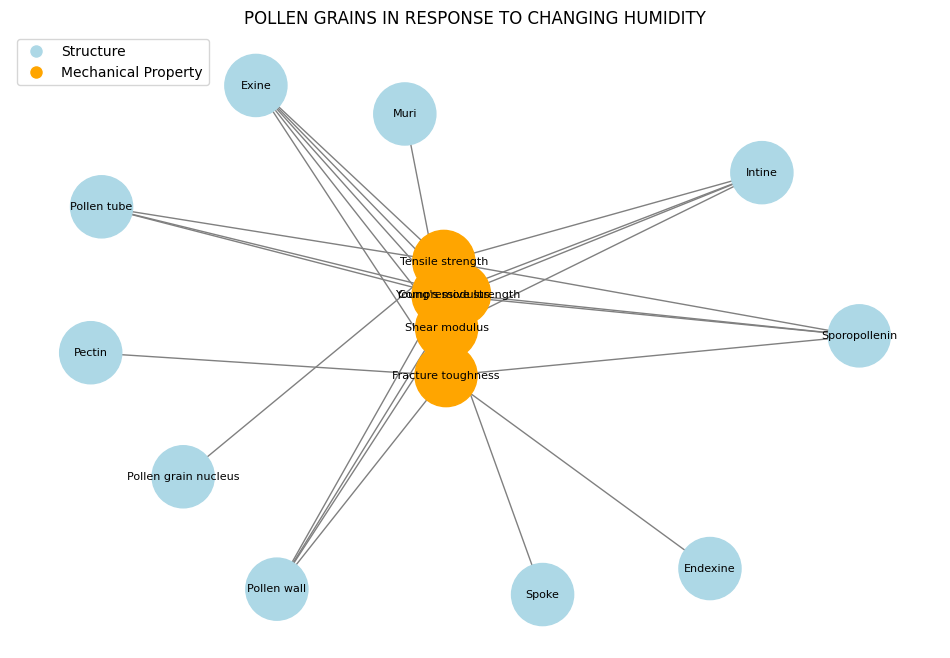

In [ ]:
# BASIC GRAPH

def plot_graph(edges, material, stimuli):
    """Create and plot a graph from property-structure edges."""
    G = nx.DiGraph()
    for edge in edges:
        G.add_edge(edge["property"], edge["structure"])

    node_colors = ["orange" if node in [e["property"] for e in edges] else "lightblue" for node in G.nodes]

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42, k=0.5) 
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, edge_color="gray", arrowsize=20)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Structure', markerfacecolor='lightblue', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Mechanical Property', markerfacecolor='orange', markersize=10)
    ]
    plt.legend(handles=legend_elements, loc="upper left")

    title = f"{material} in response to changing {stimuli}"
    plt.title(title.upper())
    plt.axis("off")
    plt.show()

plot_graph(edges, material, stimuli)

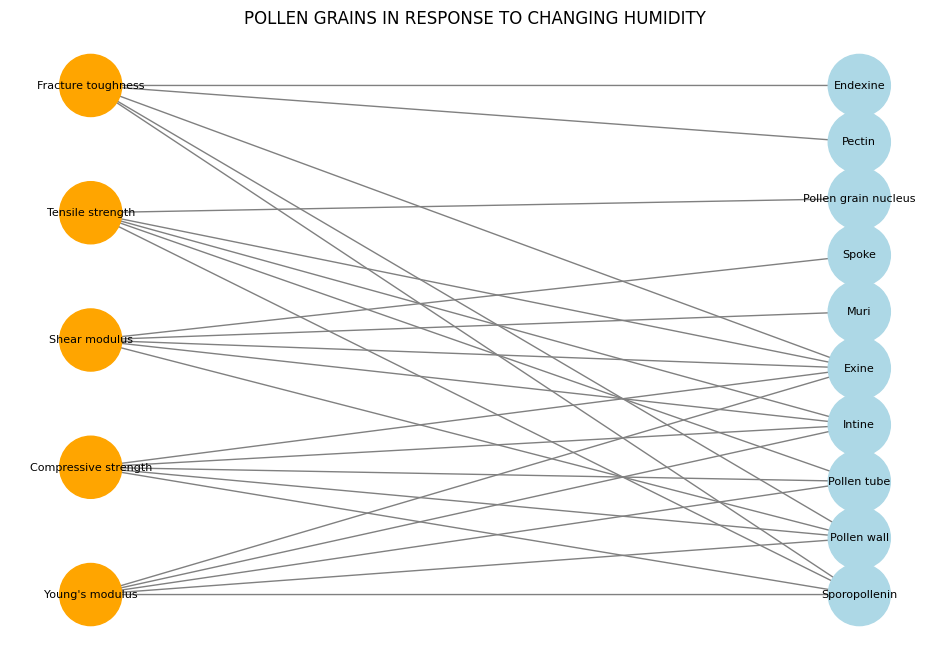

In [ ]:
#BIPARTITE GRAPH 

from networkx.algorithms import bipartite

def plot_bipartite_graph(edges, material, stimuli):
    """Plot the graph with a bipartite layout."""
    G = nx.DiGraph()

    for edge in edges:
        G.add_edge(edge["property"], edge["structure"])
    
    properties = {e["property"] for e in edges}
    structures = {e["structure"] for e in edges}
    
    pos = nx.bipartite_layout(G, properties)

    node_colors = ["orange" if node in properties else "lightblue" for node in G.nodes]

    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, edge_color="gray", arrowsize=20)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Structure', markerfacecolor='lightblue', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Mechanical Property', markerfacecolor='orange', markersize=10)
    ]
    title = f"{material} in response to changing {stimuli}"
    plt.title(title.upper())
    plt.axis("off")
    plt.show()

plot_bipartite_graph(edges, material, stimuli)


# Load Properties to Engineered Designs Workflow
This workflow takes in a user-defined input of material properties (compressive strength, fracture toughness) and a material subject (plants, pollen grains) and then generates related structures found in that subject that correlate with that property. Then using the final structures, a bioinspired engineered design is proposed.

In [ ]:
import itertools
import pandas as pd
import json
import IPython.display as ipd

def extract_bullet_points(response_text):
    """Extract bullet points or numbered points from a response."""
    lines = response_text.split('\n')
    bullet_points = set()
    for line in lines:
        line = line.strip()
        if line.startswith(('- ', '• ', '* ')):
            bullet_points.add(line[2:].strip())
        elif line and line[0].isdigit() and line[1:3] == '. ':
            bullet_points.add(line[3:].strip())
        elif line.startswith('[') and line[1].isdigit() and line[2] == ']':
            bullet_points.add(line[3:].strip())
    return list(bullet_points)

def generate_structures(property, material):
    """Generate a list of structures relevant to a given property."""
    prompt = f"List the 10 most important structures and architectures found in {material} that influence its {property}. Provide the list in bullet point format, without any explanations or additional context. List only 10 or less."
    data_for_df = []
    response = query_engine.query(prompt)
    questions = extract_bullet_points(response.response)
    for ques in questions:
        data_for_df.append({"Material": material, "Property": property, "Potential Structures": ques})
    df = pd.DataFrame(data_for_df, columns=["Material", "Property", "Potential Structures"])
    return df

def generate_strucanswers(df):
    """Generate concise explanations for each structure"""
    answers = []
    for idx, row in df.iterrows():
        question = row["Potential Structures"]
        material = row["Material"]
        property = row["Property"]
        txt = f"Describe concisely how {question} may contribute to {property} in {material}. Focus on its primary mechanism or role, and critically assess its significance. No citations."
        answer = query_engine.query(txt).response
        answers.append(answer)
        df.at[idx, "Structure Explanation"] = answer
    return df

def narrow_down_structures(df, top_n=5):
    """ Query the LLM to evaluate the significance of each structure, narrow down the list to the top N structures, and provide concise rationales for the selection."""
    material = df["Material"].iloc[0]
    property = df["Property"].iloc[0]

    structures_explanations = "\n".join(
        f"- {structure}: {explanation}"
        for structure, explanation in zip(df["Potential Structures"], df["Structure Explanation"])
    )
    prompt = (
        f"The following is a list of universal structures in pollen grains or pollen-based materials and how they contribute to {property}:\n\n"
        f"{structures_explanations}\n\n"
        f"Based on their significance, identify the top {top_n} structures that most strongly contribute to {property}. Ensure that you select physical structures, not properties."
        f"Provide the names of the top {top_n} structures in a bullet point list, and include a one-sentence rationale for "
        f"why each structure was selected."
    )
    response = query_engine.query(prompt).response
    narrowed_down = []
    lines = response.split('\n')
    for line in lines:
        if line.startswith("- "):  
            parts = line[2:].split(":")
            if len(parts) == 2:  
                structure = parts[0].strip()
                rationale = parts[1].strip()
                narrowed_down.append({"Structure": structure, "Rationale": rationale})
    return narrowed_down

def generate_bioinspired_designs(narrowed_structures,property, material):
    """Generate analogous bioinspired, engineered design given information about the structures and mechanical properties."""
    output_data =[]
    for entry in narrowed_structures: 
        structure = entry['Structure']
        rationale = entry['Rationale']
        prompt = f"""
        Here is a structure of {material}, its mechanism, and the property of interest:

        Structure: {structure}  
        Mechanism: {rationale}  
        Property: {property}

        Based on this information, propose an engineered structure that mimics the structure and mechanism, optimized for {property}. Focus on the geometry or shape of the engineered structure.

        Be concise and specific.
        """
        response = query_engine.query(prompt).response
        output_data.append({
            "Material": material,
            "Property": property,
            "Structure": structure,
            "Structure Rationale": rationale,
            "Engineered Design": response
        })
    df = pd.DataFrame(output_data)
    return df  

def run_pedworkflow(material, property, top_n):
    finstrucs = []
    print(f"For {material}...")
    print(f"\nConsidering {property}, generating list of potential structures...")
    initialdf = generate_structures(property, material)
    print(f"\nGenerating rationales for structures...")
    initialdf = generate_strucanswers(initialdf)
    print(f"\nNarrowing down structures to top {top_n}...")
    finstrucs = narrow_down_structures(initialdf, top_n)
    print(f"\nGenerating bioinspired designs...")
    peddf = generate_bioinspired_designs(finstrucs,property, material)
    return peddf


## Inference Properties to Engineered Designs 

In [ ]:
######### USER INPUT #############

material = "pollen grains"
property = "compressive strength"
top_n = 5 #number of final structures and designs

##################################

findf = run_pedworkflow(material, property, top_n)
ipd.display(ipd.HTML(findf.to_html()))


For pollen grains...

Considering compressive strength, generating list of potential structures...

Generating rationales for structures...

Narrowing down structures to top 5...

Generating bioinspired designs...


,Material,Property,Structure,Structure Rationale,Engineered Design
0,pollen grains,compressive strength,Spiky architecture,"The spiky architecture of sunflower pollen grains contributes to compressive strength through physical mesh assembly between neighbor spikes, facilitating surface contact and more hydrogen bonds, which enhance bonding and compressive strength.","To engineer a structure that mimics the spiky architecture of sunflower pollen grains for enhanced compressive strength, we propose a hierarchical porous scaffold with conical spikes. The conical spikes will be arranged in a hexagonal pattern, similar to the spiky architecture of sunflower pollen grains. The hierarchical porous structure will allow for physical mesh assembly between neighbor spikes, facilitating surface contact and more hydrogen bonds, which will enhance bonding and compressive strength. The geometry of the engineered structure will be optimized by adjusting the size, angle, and spacing of the conical spikes to achieve the desired compressive strength. This engineered structure has potential applications in biomedical engineering, such as bone tissue engineering, where enhanced compressive strength is crucial for load-bearing applications."
1,pollen grains,compressive strength,Tough sporopollenin outer layer,"The tough sporopollenin outer layer in pollen grains contributes to compressive strength through its superior mechanical stiffness and chemical inertness, providing a robust structural framework that can withstand significant compressive forces.","An engineered structure that mimics the tough sporopollenin outer layer of pollen grains for optimized compressive strength can be a hierarchical spiky shell structure. The spiky architecture can be designed to have a high aspect ratio and a hierarchical arrangement, similar to the natural spiky surface morphology of sunflower pollen particles. The spikes can be made of a tough and chemically inert material, such as a polymer or a ceramic, to provide a robust structural framework that can withstand significant compressive forces. The hierarchical arrangement of the spikes can facilitate surface contact and more hydrogen bonds, enhancing the compressive strength of the structure. The geometry of the spikes can be optimized through computational simulations and experimental testing to achieve the desired compressive strength. This engineered structure can be used in various applications, such as reinforcing fillers, drug delivery microcapsules, and micromotors, where compressive strength is a critical property."
2,pollen grains,compressive strength,Core-shell structure,"The core-shell structure of pollen grains, consisting of an ultra-strong sporopollenin outer layer and a flexible inner layer of cellulose and pectin, may contribute to compressive strength through its hierarchical spiky surface morphology, facilitating surface contact and more hydrogen bonds, effectively transferring compression forces across one another.","The engineered structure that mimics the structure and mechanism of pollen grains, optimized for compressive strength, is a hierarchical core-shell structure with a spiky surface morphology. The core consists of a tough and strong material, such as carbon fiber or high-strength polymer, and the shell consists of a flexible and ductile material, such as aluminum or titanium. The spiky surface morphology can be achieved through a combination of surface roughness and micro/nano-scale features, such as nanowires or microspheres. The hierarchical structure can be achieved through a combination of macro-scale features, such as a layered or sandwiched structure, and micro/nano-scale features. The optimized geometry of the engineered structure should focus on maximizing surface contact and hydrogen bonding, as well as facilitating the transfer of compression forces across the structure. This can be achieved through a combination of the spiky surface morphology and the hierarchical structur